In [1]:
import numpy as np
import xarray as xr 
import pandas as pd
import datetime
from netCDF4 import Dataset
import Nio
import Ngl
import matplotlib.pyplot as plt
import matplotlib
from mpl_toolkits.basemap import Basemap
import matplotlib.ticker as ticker
from Carolina_Fonts_v1 import Open_Sans
from matplotlib.patches import Polygon

In [2]:
%matplotlib inline

In [3]:
def draw_screen_poly( lats, lons, m, label):
    x, y = m( lons, lats )
    xy = zip(x,y)
    poly = Polygon( list(xy), fill=False, label=label,edgecolor='black',lw=3, alpha=0.5, linestyle='--')
    plt.gca().add_patch(poly)

In [4]:
#lats_draw = [ -33.2, -18.5, -18.5, -33.2]
#lons_draw = [ -61.2, -61.2, -46.5, -46.5]

In [5]:
lats_draw = [ -30.0, -24.0, -24.0, -30.0]
lons_draw = [ -69.0, -69.0, -62.0, -62.0]

In [6]:
# Define function to read in CESM data 
# "variable" refers to the desired CESM variable
# "comp" refers to the CESM component name corresponding to the desired CMIP6 variable
# "model" refers to the CESM component which provides the desired variable as output
# "subset" refers to the desired spatial domain to be extracted
# "plev" is the vertical level to which data should be interpolated - MUST BE IN MB - right now only one level is supported
# "vinterp" should be set to True if vertical interpolation from model to pressure levels is necessary
# "SM" should be set to True if this function is being used to read in soil moisture data
# "passpm" should be set to True if the requested spatial subset includes the Prime Meridian
# Author: Carolina Bieri (bieri2@illinois.edu)

def read_cesm(variable, case, comp, model, subset=[288.0,320.0,-40.0,-10.0], plev=850.,vinterp=False, SM=False, exclude=False, no1=False, nolast=False):
    # Set top level directory for data
    CESM_dir     = '/glade/scratch/cab478/archive/'
    # Define file names for desired variable as well as surface pressure
    filename_var = CESM_dir + case + '/' + comp + '/hist/' + case + '.' + model + '.h0.1979-2003.nc'
    
    print(filename_var)
    
    # Set reference pressure in mb
    P0 = 1000.
    
    # Open file containing desired variable
    ds_var   = Dataset(filename_var)
    # Define date range corresponding to data: 1/1/1850 to 12/31/2014 
    if no1:
        date_rng = pd.date_range(start='1/2/1979', end='12/31/2003', freq='D')
    else:
        date_rng = pd.date_range(start='1/1/1979', end='12/31/2003', freq='D')
    date_rng = date_rng[~((date_rng.month==2) & (date_rng.day==29))]
    
    # Convert lat and lon arrays to Series
    lat = pd.Series(ds_var.variables['lat'][:])
    lon = pd.Series(ds_var.variables['lon'][:])
    
    lon_slice = lon[(lon>subset[0])&(lon<subset[1])].index.tolist()
    lat_slice = lat[(lat>subset[2])&(lat<subset[3])].index.tolist()
    
    # Perform vertical interpolation if vinterp = True
    if vinterp:
        if exclude:
            var = ds_var.variables[variable][1:-1,:,lat_slice,lon_slice]
        else:
            var = ds_var.variables[variable][:-1,:,lat_slice,lon_slice]
        
        # Read in coefficients necessary to perform vertical interpolation
        hyam  = np.asarray([0.00364346569404006, 0.00759481964632869, 0.0143566322512925, 
                            0.0246122200042009, 0.0359232500195503, 0.0431937500834465, 
                            0.0516774989664555, 0.0615204982459545, 0.0737509578466415, 
                            0.0878212302923203, 0.103317126631737, 0.121547240763903, 
                            0.142994038760662, 0.168225079774857, 0.178230673074722, 
                            0.170324325561523, 0.161022908985615, 0.150080285966396, 
                            0.137206859886646, 0.122061938047409, 0.104244712740183, 
                            0.0849791541695595, 0.0665016956627369, 0.0501967892050743, 
                            0.037188658490777, 0.028431948274374, 0.0222089774906635, 
                            0.016407382208854, 0.0110745579004288, 0.00625495356507599, 
                            0.00198940909467638, 0])
        hybm  = np.asarray([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.0196774136275053, 
                            0.062504293397069, 0.112887907773256, 0.172161616384983, 
                            0.241894043982029, 0.323930636048317, 0.420442461967468, 
                            0.524799540638924, 0.624887734651566, 0.713207691907883, 
                            0.783669710159302, 0.831102818250656, 0.864811271429062, 
                            0.896237164735794, 0.92512384057045, 0.951230525970459, 
                            0.974335998296738, 0.992556095123291])
    
        # Read in surface pressure data
        PS = (ds_var.variables['PS'][:-1,lat_slice,lon_slice])
    
        # Perform vertical interpolation to desired pressure level
        var_interp = Ngl.vinth2p((var),hyam,hybm,[plev],PS,1,P0,1,False)
        # Get rid of degenerate dimension
        out = np.squeeze(var_interp[:,0,:,:])
        
    # Process for extracting soil moisture data
    elif SM:
        # Read in SM data - first 8 layers (root zone)
        if exclude:
            var = ds_var.variables[variable][1:-1,:8,lat_slice,lon_slice]
        elif nolast:
            var = ds_var.variables[variable][:,:8,lat_slice,lon_slice]
        else:
            var = ds_var.variables[variable][:-1,:8,lat_slice,lon_slice]
        
        # Create masked array before computing weighted average 
        masked_var = np.ma.masked_array(var, np.isnan(var))                
        
        # Define array of CLM soil layer thicknesses up to layer 8
        thick   = np.array([0.02,0.04,0.06,0.08,0.12,0.16,0.2,0.24])
        # Compute layer thickness weights 
        wgts    = thick/thick.sum()
        # Perform weighted average using weights
        wgt_avg = np.ma.average(masked_var,axis=1,weights=wgts)
        # Set weighted average SM data as output array
        out     = wgt_avg.filled(np.NaN)
        
    # Do this in all other cases
    else:
        if exclude:
            out = ds_var.variables[variable][1:-1,lat_slice,lon_slice]
        else:
            out = ds_var.variables[variable][:-1,lat_slice,lon_slice]
    
    # Define xarray Data Array to hold data and metadata
    # In both cases, the convention of the longitude array is changed from 0 to 360 to -180 to 180

    lon_values = np.asarray(lon[lon_slice])
    lon_values[lon_values>=180] = lon_values[lon_values>=180] - 360.
    array = xr.DataArray(out, coords={'time':date_rng,'lat':np.array(lat[lat_slice].values), 
                                      'lon':np.array(lon_values)}, dims=['time','lat','lon'])

    return array

In [7]:
Open_Sans()

def plot_cesm(data, lat, lon, vmin, vmax, interval, ticks, cblabel, month, cmap, outfile, winds=False, U=None, V=None, plotnan=False):
    
    %matplotlib inline
    
    fig = plt.figure(figsize=(10,10))

    map = Basemap(resolution='l', projection='cyl', llcrnrlon=min(lon), urcrnrlon=max(lon), 
              llcrnrlat=min(lat), urcrnrlat=max(lat), lat_0=0, lon_0=0)

    bins = np.arange(vmin,vmax+interval,interval)
    number_bins = len(bins)-1
        
    lon_plt, lat_plt = np.meshgrid(np.asarray(lon), np.asarray(lat))
    
    xi, yi = map(np.asarray(lon_plt), np.asarray(lat_plt))
        
    fill = map.pcolormesh(xi, yi, data, vmin=vmin, vmax=vmax, cmap=cmap._resample(number_bins), alpha=1)
    
    if winds:
        plt.quiver(xi, yi, U, V, color='black',zorder=10, scale=150, headlength=3.0, headaxislength=3.0)
        
    if plotnan:
        wherenan = np.nonzero(np.isnan(data))
        xi_wherenan = xi[wherenan]
        yi_wherenan = yi[wherenan]
        plt.scatter(xi_wherenan+0.5,yi_wherenan+0.5,s=70,marker='x',color='black',alpha=0.5)
        
    map.drawcoastlines()
    map.drawcountries()
    
    draw_screen_poly(lats_draw, lons_draw, map, label='SM' )

    cb = fig.colorbar(fill, orientation='horizontal', pad=0.05, ticks=ticks)
    cb.ax.tick_params(labelsize=26)
    cb.set_label(label=cblabel, size=26)

    plt.title(month, size=30)

    plt.savefig(outfile + '.png', dpi=300)
    plt.show()

In [9]:
pcp_control_c   = read_cesm('PRECC', 'FHIST_SP_control', 'atm', 'cam')
pcp_control_l   = read_cesm('PRECL', 'FHIST_SP_control', 'atm', 'cam')

/glade/scratch/cab478/archive/FHIST_SP_control/atm/hist/FHIST_SP_control.cam.h0.1979-2003.nc
/glade/scratch/cab478/archive/FHIST_SP_control/atm/hist/FHIST_SP_control.cam.h0.1979-2003.nc


In [8]:
pcp_dry_c       = read_cesm('PRECC', 'FHIST_SP_dry', 'atm', 'cam')
pcp_dry_l       = read_cesm('PRECL', 'FHIST_SP_dry', 'atm', 'cam')

/glade/scratch/cab478/archive/FHIST_SP_dry/atm/hist/FHIST_SP_dry.cam.h0.1979-2003.nc
/glade/scratch/cab478/archive/FHIST_SP_dry/atm/hist/FHIST_SP_dry.cam.h0.1979-2003.nc


In [9]:
pcp_control_tot = pcp_control_c + pcp_control_l
pcp_dry_tot     = pcp_dry_c + pcp_dry_l

In [10]:
pcp_control_tot = pcp_control_tot.resample(time='M').mean(dim='time')
pcp_dry_tot     = pcp_dry_tot.resample(time='M').mean(dim='time')

In [11]:
pcp_control_tot_nov = pcp_control_tot.sel(time=pcp_control_tot.time.dt.month==11)
pcp_control_tot_nov = np.nanmean(pcp_control_tot_nov, axis=0)

In [12]:
pcp_control_tot_nov = pcp_control_tot_nov*1000*86400

In [13]:
diff = pcp_dry_tot - pcp_control_tot
diff = diff*1000*86400
diff_oct = diff.sel(time=diff.time.dt.month==10)
diff_nov = diff.sel(time=diff.time.dt.month==11)
diff_dec = diff.sel(time=diff.time.dt.month==12)

In [14]:
diff_comp_oct = np.nanmean(diff_oct, axis=0)
diff_comp_nov = np.nanmean(diff_nov, axis=0)
diff_comp_dec = np.nanmean(diff_dec, axis=0)

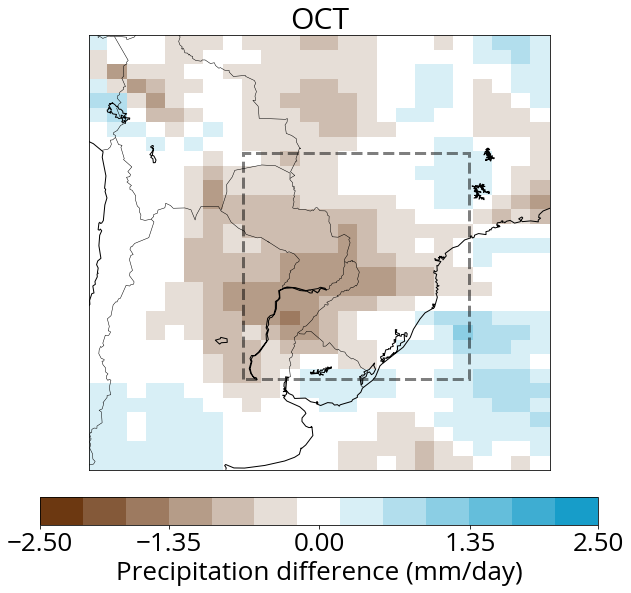

In [22]:
plot_cesm(diff_comp_oct, pcp_control_tot.coords['lat'], pcp_control_tot.coords['lon'], vmin=-2.5, vmax=2.5, interval=0.4, ticks=[-2.5,-1.35,0,1.35,2.5],
          cblabel='Precipitation difference (mm/day)', month='OCT', cmap=matplotlib.colors.LinearSegmentedColormap.from_list("", ["#6c3811","white","#179DC9"]), outfile='diff_precip_oct')

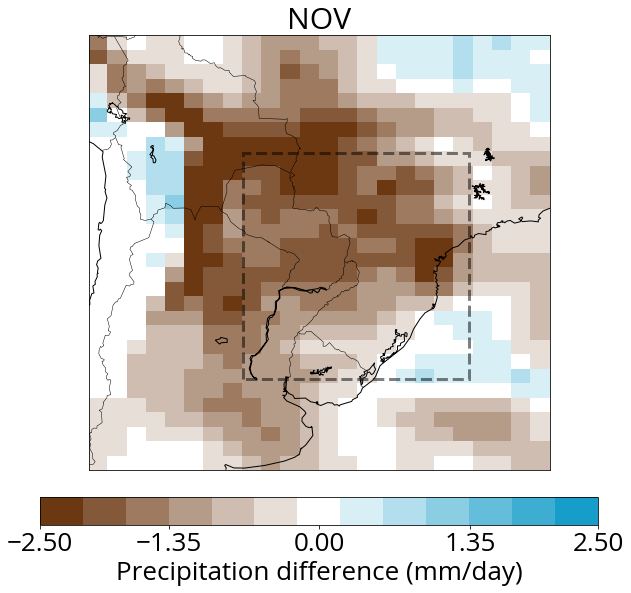

In [23]:
plot_cesm(diff_comp_nov, pcp_control_tot.coords['lat'], pcp_control_tot.coords['lon'], vmin=-2.5, vmax=2.5, interval=0.4, ticks=[-2.5,-1.35,0,1.35,2.5],
          cblabel='Precipitation difference (mm/day)', month='NOV', cmap=matplotlib.colors.LinearSegmentedColormap.from_list("", ["#6c3811","white","#179DC9"]), outfile='diff_precip_nov')

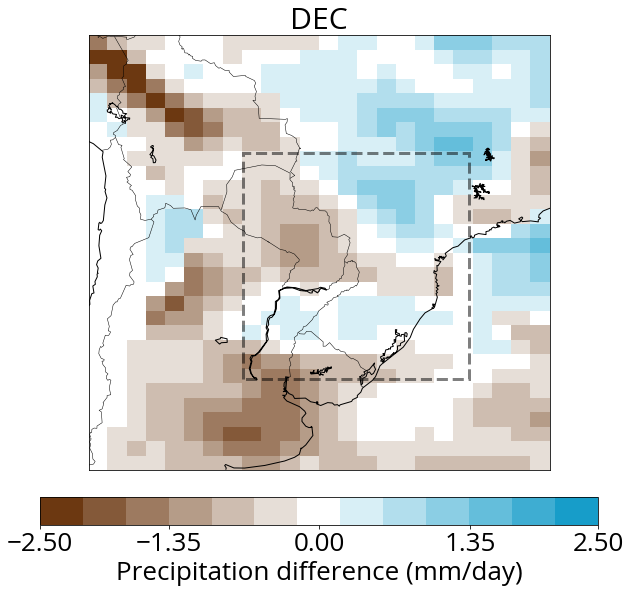

In [24]:
plot_cesm(diff_comp_dec, pcp_control_tot.coords['lat'], pcp_control_tot.coords['lon'], vmin=-2.5, vmax=2.5, interval=0.4, ticks=[-2.5,-1.35,0,1.35,2.5],
          cblabel='Precipitation difference (mm/day)', month='DEC', cmap=matplotlib.colors.LinearSegmentedColormap.from_list("", ["#6c3811","white","#179DC9"]), outfile='diff_precip_dec')

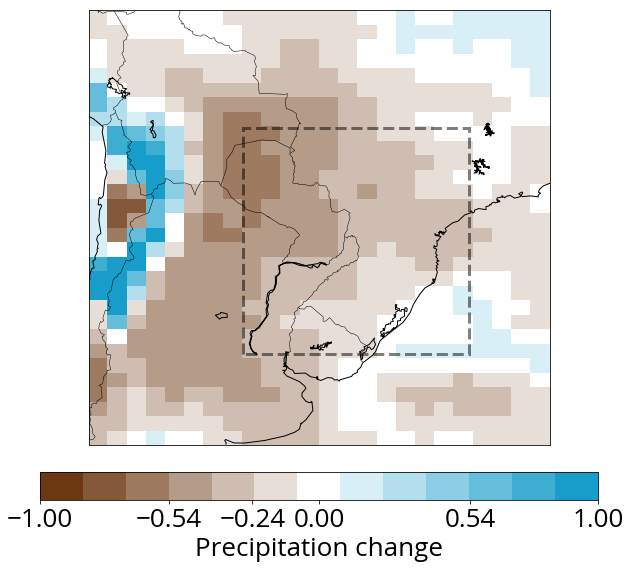

In [25]:
plot_cesm(diff_comp_nov/pcp_control_tot_nov, pcp_control_tot.coords['lat'], pcp_control_tot.coords['lon'], vmin=-1.0, vmax=1.0, interval=0.16, ticks=[-1,-0.54,-0.24,0,0.54,1],
          cblabel='Precipitation change', month='', cmap=matplotlib.colors.LinearSegmentedColormap.from_list("", ["#6c3811","white","#179DC9"]), outfile='precpet')

In [36]:
frac_chng_lat = frac_chng[((pcp_control_tot.coords['lat']>-34.0) & (pcp_control_tot.coords['lat']<-19.0)).values.nonzero()[0],:]
frac_chng_box = frac_chng_lat[:,((pcp_control_tot.coords['lon']>-62.0) & (pcp_control_tot.coords['lon']<-47.0)).values.nonzero()[0]]

In [28]:
np.mean(frac_chng_box)

-0.2689018093704058

In [7]:
t_control = read_cesm('TREFHT', 'FHIST_SP_control', 'atm', 'cam')
t_dry     = read_cesm('TREFHT', 'FHIST_SP_dry', 'atm', 'cam')

/glade/scratch/cab478/archive/FHIST_SP_control/atm/hist/FHIST_SP_control.cam.h0.1979-2003.nc
/glade/scratch/cab478/archive/FHIST_SP_dry/atm/hist/FHIST_SP_dry.cam.h0.1979-2003.nc


In [8]:
t_control = t_control.resample(time='M').mean(dim='time')
t_dry     = t_dry.resample(time='M').mean(dim='time')

In [22]:
t_control_nov = t_control.sel(time=t_control.time.dt.month==11)
t_control_nov = np.nanmean(t_control_nov, axis=0)

In [23]:
t_diff     = t_dry - t_control
t_diff_oct = t_diff.sel(time=t_diff.time.dt.month==10)
t_diff_nov = t_diff.sel(time=t_diff.time.dt.month==11)
t_diff_dec = t_diff.sel(time=t_diff.time.dt.month==12)

In [24]:
t_comp_oct = np.nanmean(t_diff_oct, axis=0)
t_comp_nov = np.nanmean(t_diff_nov, axis=0)
t_comp_dec = np.nanmean(t_diff_dec, axis=0)

In [25]:
t_control_nov = t_control_nov-273.15

In [26]:
frac_chng_t = t_comp_nov/t_control_nov 

In [27]:
frac_chng_t_lat = frac_chng_t[((t_control.coords['lat']>-34.0) & (t_control.coords['lat']<-19.0)).values.nonzero()[0],:]
frac_chng_t_box = frac_chng_t_lat[:,((t_control.coords['lon']>-62.0) & (t_control.coords['lon']<-47.0)).values.nonzero()[0]]

In [28]:
np.mean(frac_chng_t_box)

0.12505741

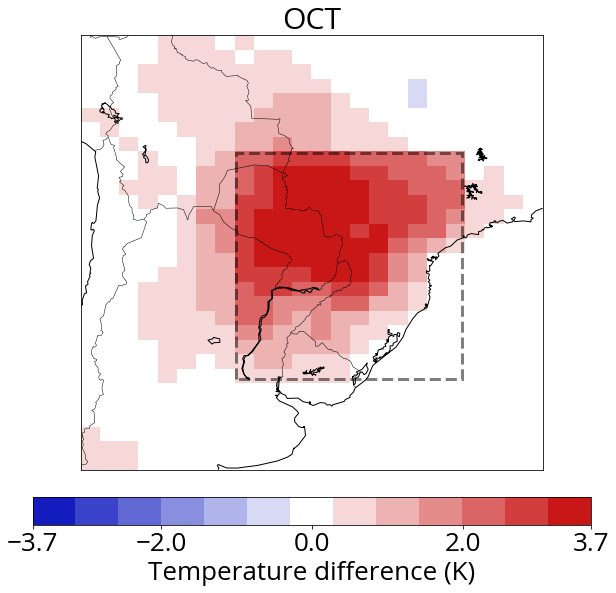

In [43]:
plot_cesm(t_comp_oct, t_control.coords['lat'], t_control.coords['lon'], vmin=-3.7, vmax=3.7, interval=0.6, ticks=[-3.7,-2.0,0,2.0,3.7],
          cblabel='Temperature difference (K)', month='OCT', cmap=matplotlib.colors.LinearSegmentedColormap.from_list("", ["#131DBF","white","#C91717"]), outfile='diff_t_oct')

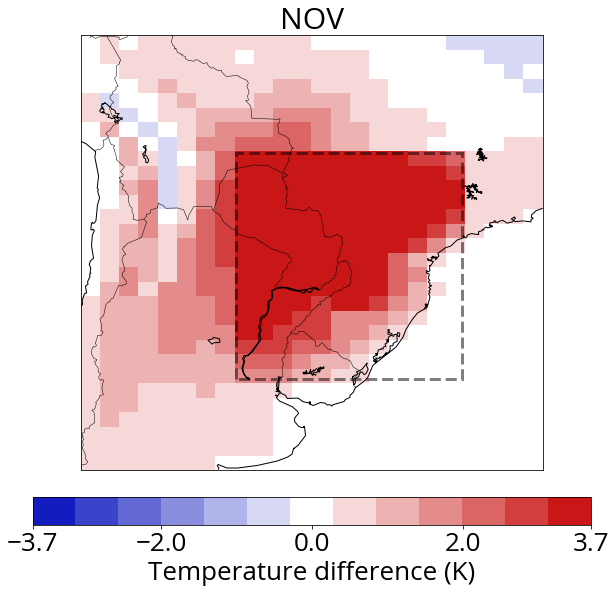

In [44]:
plot_cesm(t_comp_nov, t_control.coords['lat'], t_control.coords['lon'], vmin=-3.7, vmax=3.7, interval=0.60, ticks=[-3.7,-2,0,2,3.7],
          cblabel='Temperature difference (K)', month='NOV', cmap=matplotlib.colors.LinearSegmentedColormap.from_list("", ["#131DBF","white","#C91717"]), outfile='diff_t_nov')

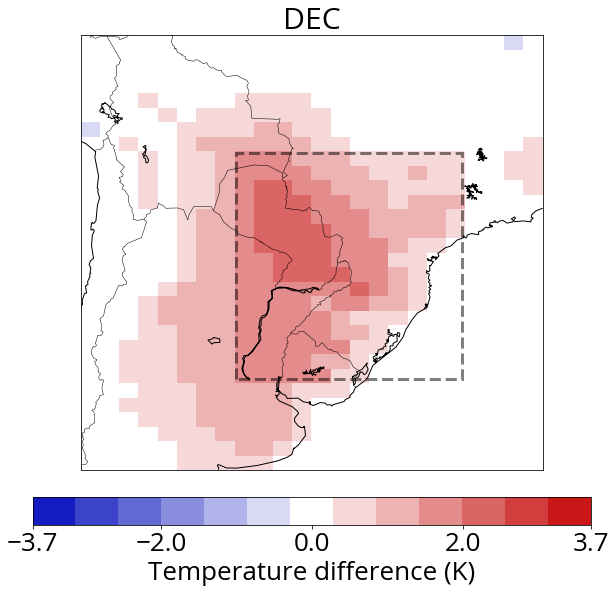

In [45]:
plot_cesm(t_comp_dec, t_control.coords['lat'], t_control.coords['lon'], vmin=-3.7, vmax=3.7, interval=0.60, ticks=[-3.7,-2,0,2,3.7],
          cblabel='Temperature difference (K)', month='DEC', cmap=matplotlib.colors.LinearSegmentedColormap.from_list("", ["#131DBF","white","#C91717"]), outfile='diff_t_dec')

In [46]:
lh_control = read_cesm('EFLX_LH_TOT', 'FHIST_SP_control', 'lnd', 'clm2', exclude=True, no1=True)
lh_dry     = read_cesm('EFLX_LH_TOT', 'FHIST_SP_dry', 'lnd', 'clm2', no1=True)

/glade/scratch/cab478/archive/FHIST_SP_control/lnd/hist/FHIST_SP_control.clm2.h0.1979-2003.nc
/glade/scratch/cab478/archive/FHIST_SP_dry/lnd/hist/FHIST_SP_dry.clm2.h0.1979-2003.nc


In [47]:
lh_control = lh_control.resample(time='M').mean(dim='time')
lh_dry     = lh_dry.resample(time='M').mean(dim='time')

/glade/u/home/cab478/anaconda3/lib/python3.7/site-packages/xarray/core/nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [48]:
lh_control_nov = lh_control.sel(time=lh_control.time.dt.month==11)
lh_control_nov = np.nanmean(lh_control_nov, axis=0)

/glade/u/home/cab478/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: Mean of empty slice
  


In [49]:
lh_diff  = lh_dry - lh_control
lh_diff_oct = lh_diff.sel(time=lh_diff.time.dt.month==10)
lh_diff_nov = lh_diff.sel(time=lh_diff.time.dt.month==11)
lh_diff_dec = lh_diff.sel(time=lh_diff.time.dt.month==12)

In [50]:
lh_diff_comp_oct = np.nanmean(lh_diff_oct, axis=0)
lh_diff_comp_nov = np.nanmean(lh_diff_nov, axis=0)
lh_diff_comp_dec = np.nanmean(lh_diff_dec, axis=0)

/glade/u/home/cab478/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: Mean of empty slice
  """Entry point for launching an IPython kernel.
/glade/u/home/cab478/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: Mean of empty slice
  
/glade/u/home/cab478/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: Mean of empty slice
  This is separate from the ipykernel package so we can avoid doing imports until


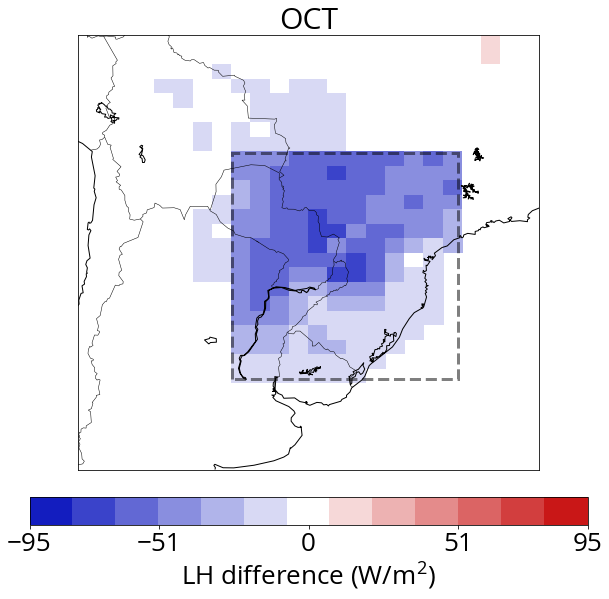

In [51]:
plot_cesm(lh_diff_comp_oct, lh_control.coords['lat'], lh_control.coords['lon'], vmin=-95, vmax=95, interval=14.7, ticks=[-95,-51,0,51,95],
          cblabel='LH difference ($W/m^2$)', month='OCT', cmap=matplotlib.colors.LinearSegmentedColormap.from_list("", ["#131DBF","white","#C91717"]), outfile='diff_lh_oct')

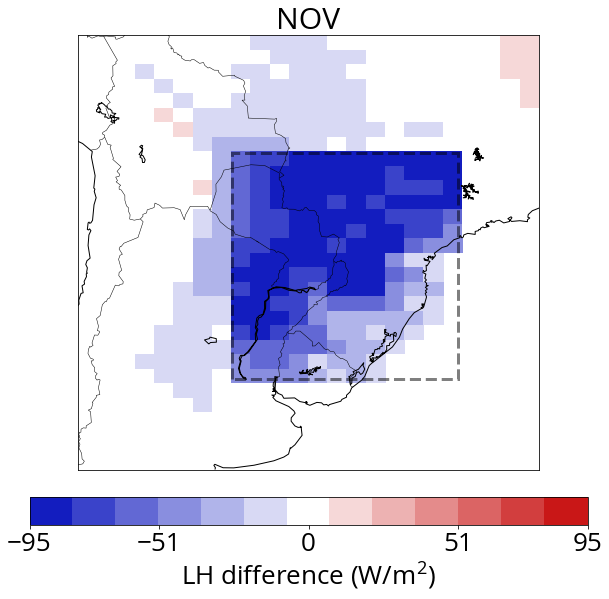

In [52]:
plot_cesm(lh_diff_comp_nov, lh_control.coords['lat'], lh_control.coords['lon'], vmin=-95, vmax=95, interval=14.7, ticks=[-95,-51,0,51,95],
          cblabel='LH difference ($W/m^2$)', month='NOV', cmap=matplotlib.colors.LinearSegmentedColormap.from_list("", ["#131DBF","white","#C91717"]), outfile='diff_lh_nov')

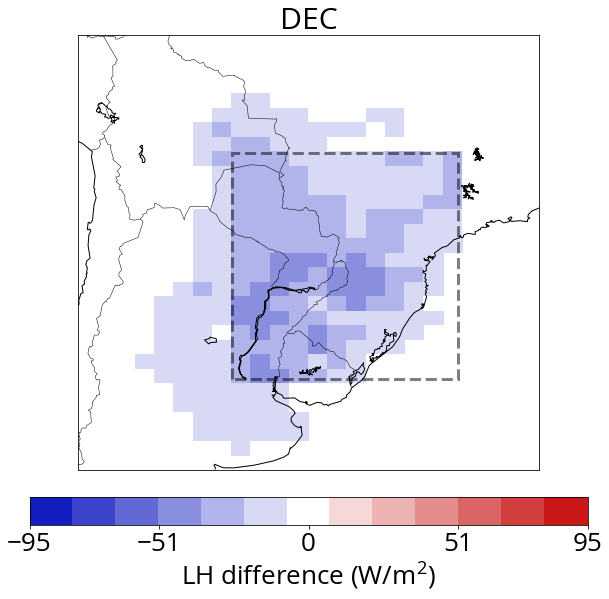

In [53]:
plot_cesm(lh_diff_comp_dec, lh_control.coords['lat'], lh_control.coords['lon'], vmin=-95, vmax=95, interval=14.7, ticks=[-95,-51,0,51,95],
          cblabel='LH difference ($W/m^2$)', month='DEC', cmap=matplotlib.colors.LinearSegmentedColormap.from_list("", ["#131DBF","white","#C91717"]), outfile='diff_lh_dec')

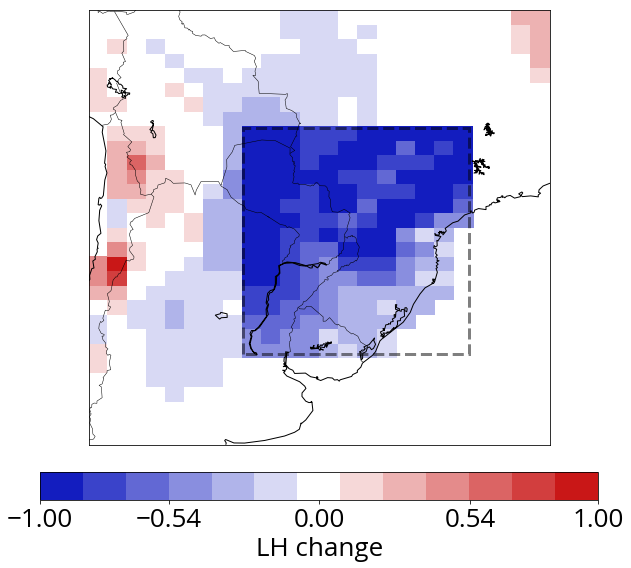

In [54]:
plot_cesm(lh_diff_comp_nov/lh_control_nov, lh_control.coords['lat'], lh_control.coords['lon'], vmin=-1, vmax=1, interval=0.16, ticks=[-1,-0.54,0,0.54,1],
          cblabel='LH change', month='', cmap=matplotlib.colors.LinearSegmentedColormap.from_list("", ["#131DBF","white","#C91717"]), outfile='et_precp')

In [55]:
frac_chng = lh_diff_comp_nov/lh_control_nov
frac_chng.shape

(31, 25)

In [56]:
frac_chng_lat = frac_chng[((lh_control.coords['lat']>-34.0) & (lh_control.coords['lat']<-19.0)).values.nonzero()[0],:]
frac_chng_box = frac_chng_lat[:,((lh_control.coords['lon']>-62.0) & (lh_control.coords['lon']<-47.0)).values.nonzero()[0]]

In [57]:
np.nanmean(frac_chng_box)

-0.6866686

In [42]:
sh_control = read_cesm('FSH', 'FHIST_SP_control', 'lnd', 'clm2', exclude=True, no1=True)
sh_dry     = read_cesm('FSH', 'FHIST_SP_dry', 'lnd', 'clm2', no1=True)

/glade/scratch/cab478/archive/FHIST_SP_control/lnd/hist/FHIST_SP_control.clm2.h0.1979-2003.nc
/glade/scratch/cab478/archive/FHIST_SP_dry/lnd/hist/FHIST_SP_dry.clm2.h0.1979-2003.nc


In [43]:
sh_control = sh_control.resample(time='M').mean(dim='time')
sh_dry     = sh_dry.resample(time='M').mean(dim='time')

/glade/u/home/cab478/anaconda3/lib/python3.7/site-packages/xarray/core/nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [44]:
sh_control_nov = sh_control.sel(time=sh_control.time.dt.month==11)
sh_control_nov = np.nanmean(sh_control_nov, axis=0)

/glade/u/home/cab478/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: Mean of empty slice
  


In [45]:
sh_diff  = sh_dry - sh_control
sh_diff_oct = sh_diff.sel(time=sh_diff.time.dt.month==10)
sh_diff_nov = sh_diff.sel(time=sh_diff.time.dt.month==11)
sh_diff_dec = sh_diff.sel(time=sh_diff.time.dt.month==12)

In [46]:
sh_diff_comp_oct = np.nanmean(sh_diff_oct, axis=0)
sh_diff_comp_nov = np.nanmean(sh_diff_nov, axis=0)
sh_diff_comp_dec = np.nanmean(sh_diff_dec, axis=0)

/glade/u/home/cab478/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: Mean of empty slice
  """Entry point for launching an IPython kernel.
/glade/u/home/cab478/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: Mean of empty slice
  
/glade/u/home/cab478/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: Mean of empty slice
  This is separate from the ipykernel package so we can avoid doing imports until


In [47]:
frac_chng_sh = sh_diff_comp_nov/sh_control_nov
frac_chng_sh_lat = frac_chng_sh[((sh_control.coords['lat']>-34.0) & (sh_control.coords['lat']<-19.0)).values.nonzero()[0],:]
frac_chng_sh_box = frac_chng_sh_lat[:,((sh_control.coords['lon']>-62.0) & (sh_control.coords['lon']<-47.0)).values.nonzero()[0]]

In [58]:
np.nanmean(frac_chng_sh_box)

1.1784426

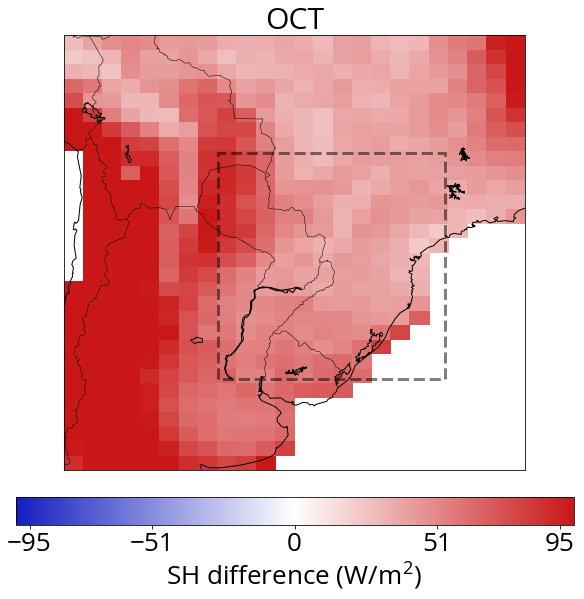

In [66]:
plot_cesm(sh_control_nov, sh_control.coords['lat'], sh_control.coords['lon'], vmin=-100, vmax=100, interval=0.15, ticks=[-95,-51,0,51,95],
          cblabel='SH difference ($W/m^2$)', month='OCT', cmap=matplotlib.colors.LinearSegmentedColormap.from_list("", ["#131DBF","white","#C91717"]), outfile='diff_sh_oct')

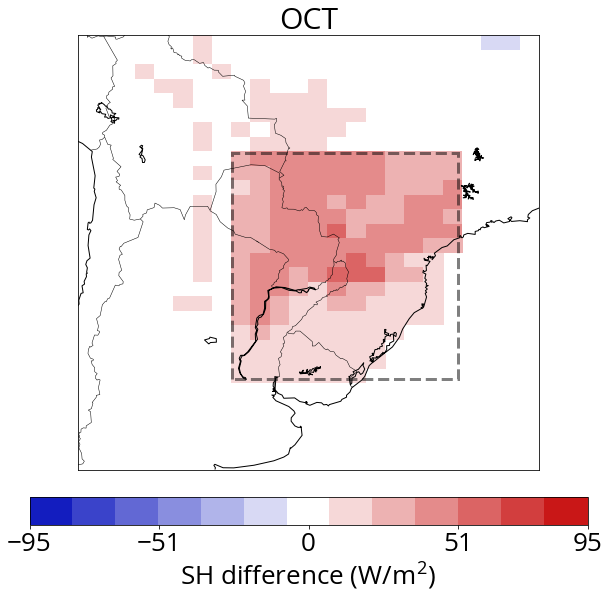

In [62]:
plot_cesm(sh_diff_comp_oct, sh_control.coords['lat'], sh_control.coords['lon'], vmin=-95, vmax=95, interval=14.7, ticks=[-95,-51,0,51,95],
          cblabel='SH difference ($W/m^2$)', month='OCT', cmap=matplotlib.colors.LinearSegmentedColormap.from_list("", ["#131DBF","white","#C91717"]), outfile='diff_sh_oct')

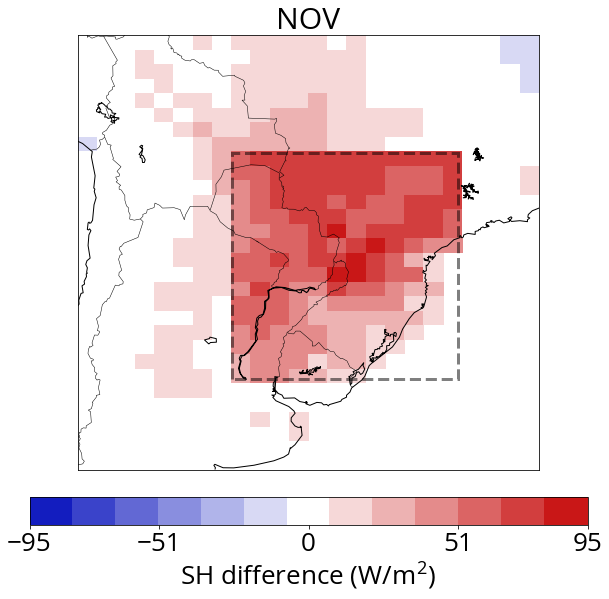

In [63]:
plot_cesm(sh_diff_comp_nov, sh_control.coords['lat'], sh_control.coords['lon'], vmin=-95, vmax=95, interval=14.7, ticks=[-95,-51,0,51,95],
          cblabel='SH difference ($W/m^2$)', month='NOV', cmap=matplotlib.colors.LinearSegmentedColormap.from_list("", ["#131DBF","white","#C91717"]), outfile='diff_sh_nov')

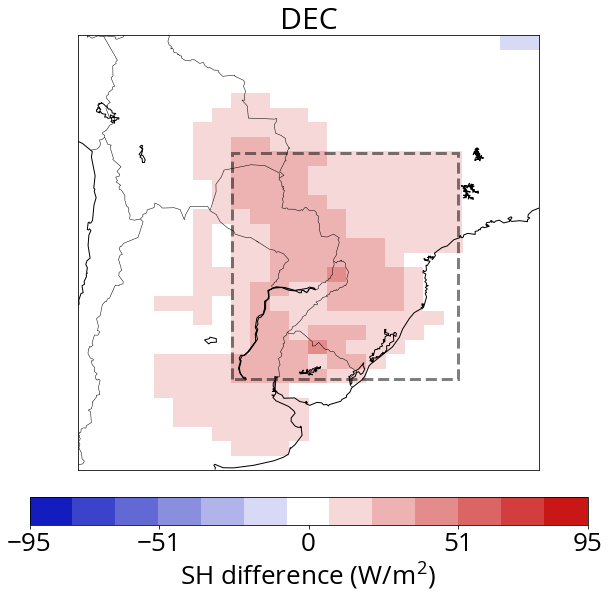

In [64]:
plot_cesm(sh_diff_comp_dec, sh_control.coords['lat'], sh_control.coords['lon'], vmin=-95, vmax=95, interval=14.7, ticks=[-95,-51,0,51,95],
          cblabel='SH difference ($W/m^2$)', month='DEC', cmap=matplotlib.colors.LinearSegmentedColormap.from_list("", ["#131DBF","white","#C91717"]), outfile='diff_sh_dec')

In [65]:
u_control = read_cesm('U', 'FHIST_SP_control', 'atm', 'cam', plev=850., vinterp = True)
u_dry     = read_cesm('U', 'FHIST_SP_dry', 'atm', 'cam', plev=850., vinterp = True)

/glade/scratch/cab478/archive/FHIST_SP_control/atm/hist/FHIST_SP_control.cam.h0.1979-2003.nc
/glade/scratch/cab478/archive/FHIST_SP_dry/atm/hist/FHIST_SP_dry.cam.h0.1979-2003.nc


In [66]:
v_control = read_cesm('V', 'FHIST_SP_control', 'atm', 'cam', plev=850., vinterp = True)
v_dry     = read_cesm('V', 'FHIST_SP_dry', 'atm', 'cam', plev=850., vinterp = True)

/glade/scratch/cab478/archive/FHIST_SP_control/atm/hist/FHIST_SP_control.cam.h0.1979-2003.nc
/glade/scratch/cab478/archive/FHIST_SP_dry/atm/hist/FHIST_SP_dry.cam.h0.1979-2003.nc


In [67]:
u_control = u_control.resample(time='M').mean(dim='time')
u_dry     = u_dry.resample(time='M').mean(dim='time')

In [68]:
v_control = v_control.resample(time='M').mean(dim='time')
v_dry     = v_dry.resample(time='M').mean(dim='time')

In [69]:
u_control = u_control.where(u_control<100)
u_dry     = u_dry.where(u_dry<100)
v_control = v_control.where(v_control<100)
v_dry     = v_dry.where(v_dry<100)

In [70]:
u_diff  = u_dry - u_control
u_diff[np.nonzero(np.asarray(u_diff) > 100)] = np.NaN
u_diff_oct = u_diff.sel(time=u_diff.time.dt.month==10)
u_diff_nov = u_diff.sel(time=u_diff.time.dt.month==11)
u_diff_dec = u_diff.sel(time=u_diff.time.dt.month==12)

/glade/u/home/cab478/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in greater
  


In [71]:
v_diff  = v_dry - v_control
v_diff[np.nonzero(np.asarray(v_diff) > 100)] = np.NaN
v_diff_oct = v_diff.sel(time=v_diff.time.dt.month==10)
v_diff_nov = v_diff.sel(time=v_diff.time.dt.month==11)
v_diff_dec = v_diff.sel(time=v_diff.time.dt.month==12)

/glade/u/home/cab478/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in greater
  


In [72]:
u_diff_comp_oct = np.nanmean(u_diff_oct, axis=0)
u_diff_comp_nov = np.nanmean(u_diff_nov, axis=0)
u_diff_comp_dec = np.nanmean(u_diff_dec, axis=0)

/glade/u/home/cab478/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: Mean of empty slice
  """Entry point for launching an IPython kernel.
/glade/u/home/cab478/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: Mean of empty slice
  
/glade/u/home/cab478/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: Mean of empty slice
  This is separate from the ipykernel package so we can avoid doing imports until


In [73]:
v_diff_comp_oct = np.nanmean(v_diff_oct, axis=0)
v_diff_comp_nov = np.nanmean(v_diff_nov, axis=0)
v_diff_comp_dec = np.nanmean(v_diff_dec, axis=0)

/glade/u/home/cab478/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: Mean of empty slice
  """Entry point for launching an IPython kernel.
/glade/u/home/cab478/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: Mean of empty slice
  
/glade/u/home/cab478/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: Mean of empty slice
  This is separate from the ipykernel package so we can avoid doing imports until


In [8]:
gh_control = read_cesm('Z3', 'FHIST_SP_control', 'atm', 'cam', plev=850., vinterp = True)
gh_dry     = read_cesm('Z3', 'FHIST_SP_dry', 'atm', 'cam', plev=850., vinterp = True)

/glade/scratch/cab478/archive/FHIST_SP_control/atm/hist/FHIST_SP_control.cam.h0.1979-2003.nc


KeyboardInterrupt: 

In [92]:
gh_control = gh_control.where(gh_control<1e+30)
gh_dry     = gh_dry.where(gh_dry<1e+30)

In [93]:
gh_control = gh_control.resample(time='M').mean(dim='time')
gh_dry     = gh_dry.resample(time='M').mean(dim='time')

/glade/u/home/cab478/anaconda3/lib/python3.7/site-packages/xarray/core/nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [104]:
gh_diff  = gh_dry - gh_control
gh_diff[np.nonzero(np.asarray(gh_diff) > 100)] = np.NaN
gh_diff_oct = gh_diff.sel(time=gh_diff.time.dt.month==10)
gh_diff_nov = gh_diff.sel(time=gh_diff.time.dt.month==11)
gh_diff_dec = gh_diff.sel(time=gh_diff.time.dt.month==12)

/glade/u/home/cab478/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in greater
  


In [122]:
gh_diff_comp_oct = np.nanmean(gh_diff_oct, axis=0)
gh_diff_comp_nov = np.nanmean(gh_diff_nov, axis=0)
gh_diff_comp_dec = np.nanmean(gh_diff_dec, axis=0)

gh_diff_comp_dec[np.nonzero(gh_diff_comp_dec > 4)] = np.NaN

/glade/u/home/cab478/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: Mean of empty slice
  """Entry point for launching an IPython kernel.
/glade/u/home/cab478/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: Mean of empty slice
  
/glade/u/home/cab478/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: Mean of empty slice
  This is separate from the ipykernel package so we can avoid doing imports until
/glade/u/home/cab478/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in greater
  """


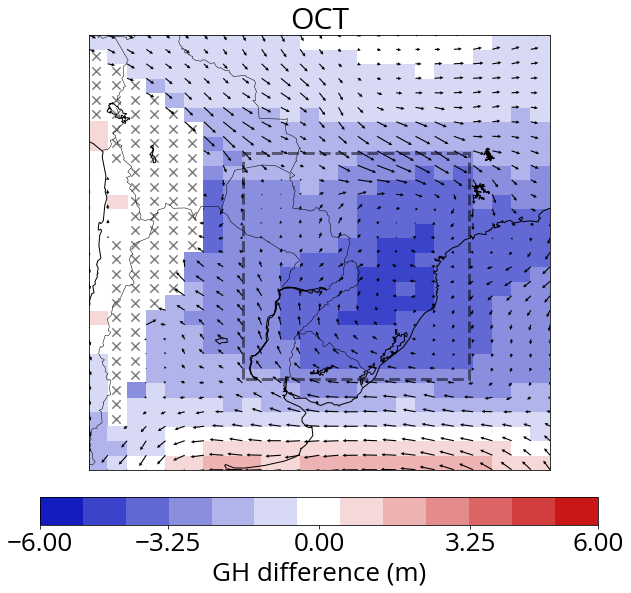

In [106]:
plot_cesm(gh_diff_comp_oct, gh_control.coords['lat'], gh_control.coords['lon'], vmin=-6.0, vmax=6.0, interval=0.95, ticks=[-6,-3.25,0,3.25,6],
          cblabel='GH difference (m)', month='OCT', cmap=matplotlib.colors.LinearSegmentedColormap.from_list("", ["#131DBF","white","#C91717"]), outfile='diff_gh_oct',
          winds=True, U=u_diff_comp_oct, V=v_diff_comp_oct, plotnan=True)

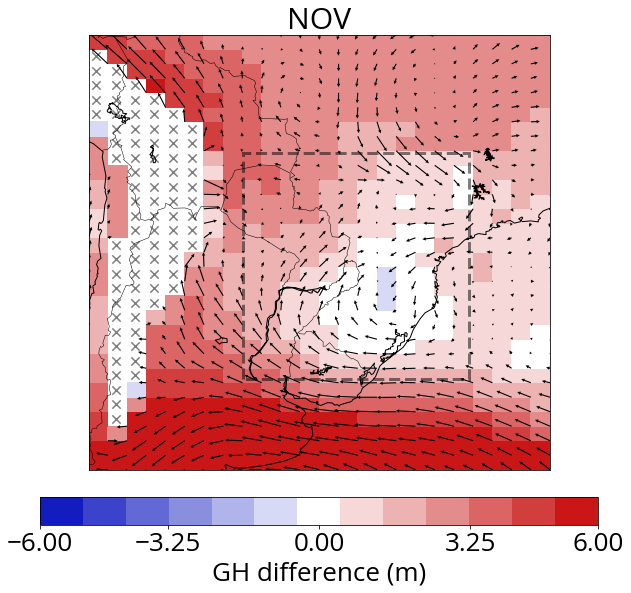

In [107]:
plot_cesm(gh_diff_comp_nov, gh_control.coords['lat'], gh_control.coords['lon'], vmin=-6.0, vmax=6.0, interval=0.95, ticks=[-6,-3.25,0,3.25,6],
          cblabel='GH difference (m)', month='NOV', cmap=matplotlib.colors.LinearSegmentedColormap.from_list("", ["#131DBF","white","#C91717"]), outfile='diff_gh_nov',
          winds=True, U=u_diff_comp_nov, V=v_diff_comp_nov, plotnan=True)

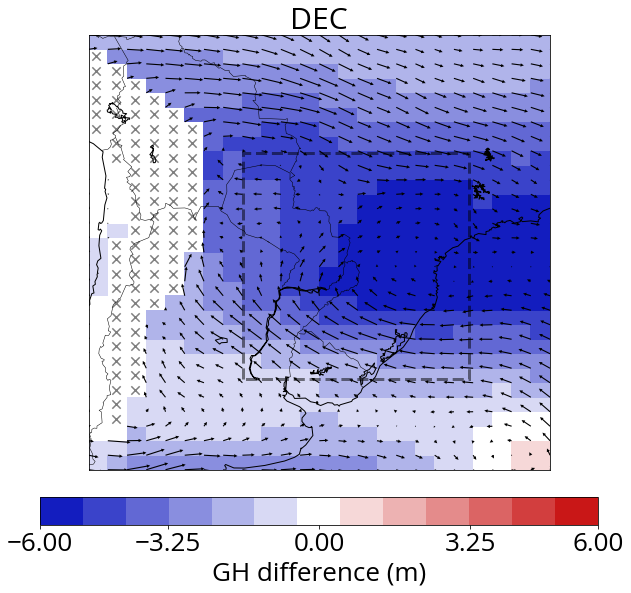

In [123]:
plot_cesm(gh_diff_comp_dec, gh_control.coords['lat'], gh_control.coords['lon'], vmin=-6.0, vmax=6.0, interval=0.95, ticks=[-6,-3.25,0,3.25,6],
          cblabel='GH difference (m)', month='DEC', cmap=matplotlib.colors.LinearSegmentedColormap.from_list("", ["#131DBF","white","#C91717"]), outfile='diff_gh_dec',
          winds=True, U=u_diff_comp_dec, V=v_diff_comp_dec, plotnan=True)

In [124]:
sm_control = read_cesm('H2OSOI', 'FHIST_SP_control', 'lnd', 'clm2', exclude=True, no1=True, SM=True)
sm_dry     = read_cesm('H2OSOI', 'FHIST_SP_dry', 'lnd', 'clm2', no1=True, SM=True)

/glade/scratch/cab478/archive/FHIST_SP_control/lnd/hist/FHIST_SP_control.clm2.h0.1979-2003.nc
/glade/scratch/cab478/archive/FHIST_SP_dry/lnd/hist/FHIST_SP_dry.clm2.h0.1979-2003.nc


In [125]:
sm_control = sm_control.resample(time='M').mean(dim='time')
sm_dry     = sm_dry.resample(time='M').mean(dim='time')

/glade/u/home/cab478/anaconda3/lib/python3.7/site-packages/xarray/core/nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [126]:
sm_diff  = sm_dry - sm_control
sm_diff_oct = sm_diff.sel(time=sm_diff.time.dt.month==10)
sm_diff_nov = sm_diff.sel(time=sm_diff.time.dt.month==11)
sm_diff_dec = sm_diff.sel(time=sm_diff.time.dt.month==12)

In [127]:
sm_diff_comp_oct = np.nanmean(sm_diff_oct, axis=0)
sm_diff_comp_nov = np.nanmean(sm_diff_nov, axis=0)
sm_diff_comp_dec = np.nanmean(sm_diff_dec, axis=0)

/glade/u/home/cab478/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: Mean of empty slice
  """Entry point for launching an IPython kernel.
/glade/u/home/cab478/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: Mean of empty slice
  
/glade/u/home/cab478/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: Mean of empty slice
  This is separate from the ipykernel package so we can avoid doing imports until


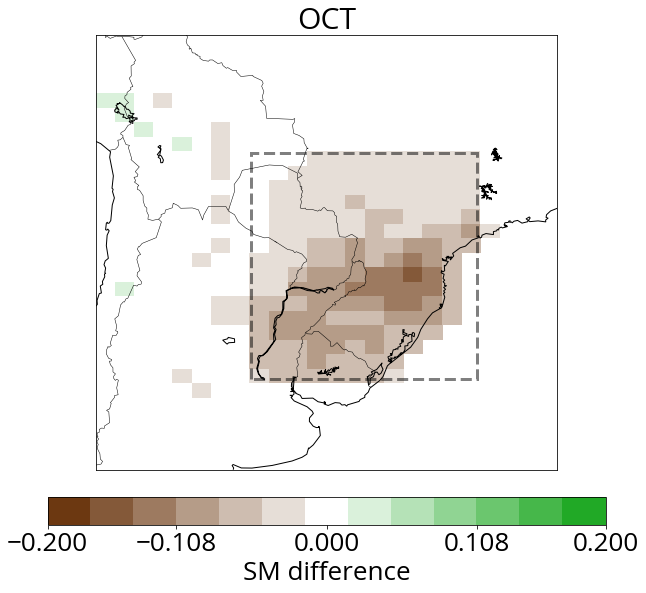

In [128]:
plot_cesm(sm_diff_comp_oct, sm_control.coords['lat'], sm_control.coords['lon'], vmin=-0.2, vmax=0.2, interval=0.033, ticks=[-0.2,-0.108,0,0.108,0.2],
          cblabel='SM difference', month='OCT', cmap=matplotlib.colors.LinearSegmentedColormap.from_list("", ["#6c3811","white","#21A926"]), outfile='diff_sm_oct')

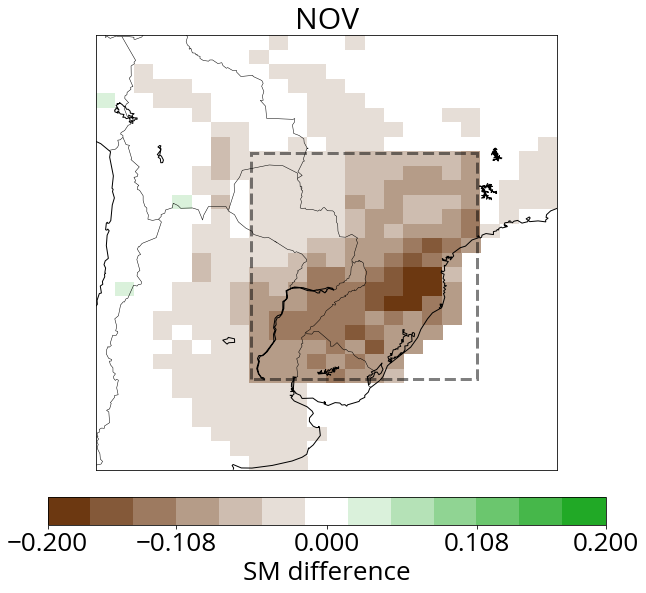

In [129]:
plot_cesm(sm_diff_comp_nov, sm_control.coords['lat'], sm_control.coords['lon'], vmin=-0.2, vmax=0.2, interval=0.033, ticks=[-0.2,-0.108,0,0.108,0.2],
          cblabel='SM difference', month='NOV', cmap=matplotlib.colors.LinearSegmentedColormap.from_list("", ["#6c3811","white","#21A926"]), outfile='diff_sm_nov')

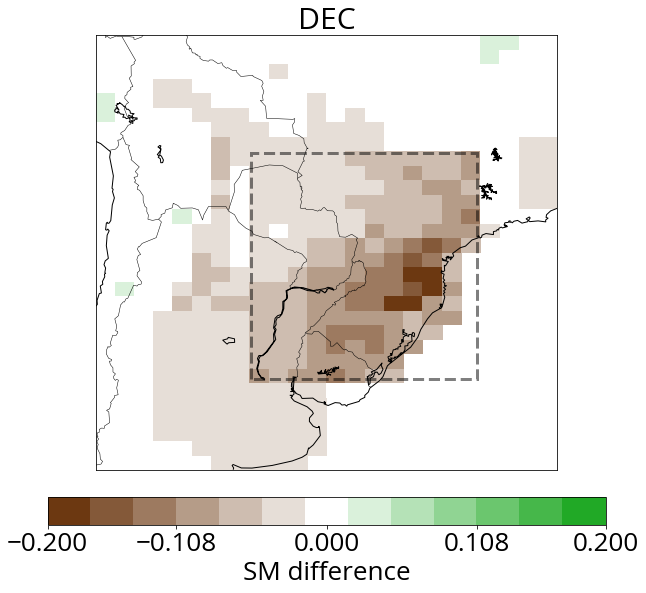

In [130]:
plot_cesm(sm_diff_comp_dec, sm_control.coords['lat'], sm_control.coords['lon'], vmin=-0.2, vmax=0.2, interval=0.033, ticks=[-0.2,-0.108,0,0.108,0.2],
          cblabel='SM difference', month='DEC', cmap=matplotlib.colors.LinearSegmentedColormap.from_list("", ["#6c3811","white","#21A926"]), outfile='diff_sm_dec')

In [10]:
pcp_dry_c_nal = read_cesm('PRECC', 'FHIST_SP_dry_NAL', 'atm', 'cam')
pcp_dry_l_nal = read_cesm('PRECL', 'FHIST_SP_dry_NAL', 'atm', 'cam')

/glade/scratch/cab478/archive/FHIST_SP_dry_NAL/atm/hist/FHIST_SP_dry_NAL.cam.h0.1979-2003.nc
/glade/scratch/cab478/archive/FHIST_SP_dry_NAL/atm/hist/FHIST_SP_dry_NAL.cam.h0.1979-2003.nc


In [11]:
pcp_control_tot = pcp_control_c + pcp_control_l
pcp_dry_nal_tot = pcp_dry_c_nal + pcp_dry_l_nal

In [12]:
pcp_control_tot = pcp_control_tot.resample(time='M').mean(dim='time')
pcp_dry_nal_tot = pcp_dry_nal_tot.resample(time='M').mean(dim='time')

In [13]:
diff_nal = pcp_dry_nal_tot - pcp_control_tot
diff_nal = diff_nal*1000*86400
diff_oct_nal = diff_nal.sel(time=diff_nal.time.dt.month==10)
diff_nov_nal = diff_nal.sel(time=diff_nal.time.dt.month==11)
diff_dec_nal = diff_nal.sel(time=diff_nal.time.dt.month==12)

In [14]:
diff_comp_oct_nal = np.nanmean(diff_oct_nal, axis=0)
diff_comp_nov_nal = np.nanmean(diff_nov_nal, axis=0)
diff_comp_dec_nal = np.nanmean(diff_dec_nal, axis=0)

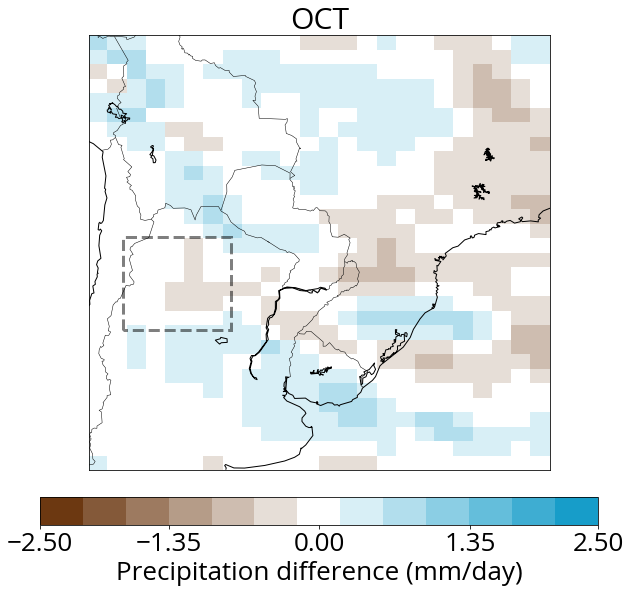

In [15]:
plot_cesm(diff_comp_oct_nal, pcp_control_tot.coords['lat'], pcp_control_tot.coords['lon'], vmin=-2.5, vmax=2.5, interval=0.4, ticks=[-2.5,-1.35,0,1.35,2.5],
          cblabel='Precipitation difference (mm/day)', month='OCT', cmap=matplotlib.colors.LinearSegmentedColormap.from_list("", ["#6c3811","white","#179DC9"]), outfile='diff_precip_oct_nal')

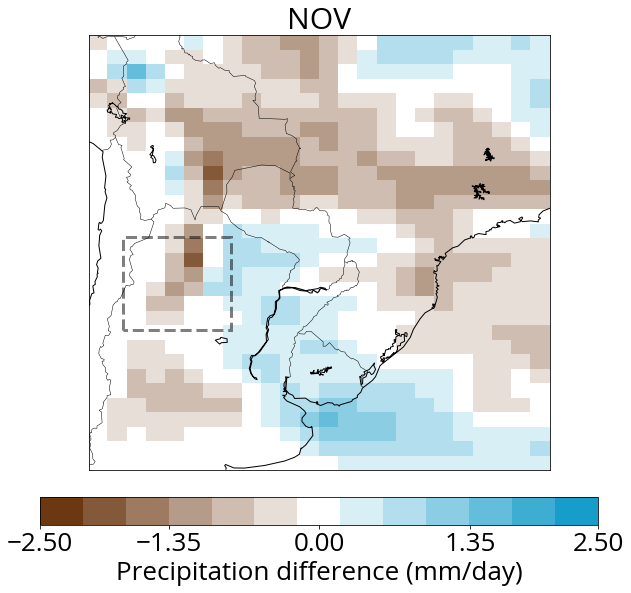

In [16]:
plot_cesm(diff_comp_nov_nal, pcp_control_tot.coords['lat'], pcp_control_tot.coords['lon'], vmin=-2.5, vmax=2.5, interval=0.4, ticks=[-2.5,-1.35,0,1.35,2.5],
          cblabel='Precipitation difference (mm/day)', month='NOV', cmap=matplotlib.colors.LinearSegmentedColormap.from_list("", ["#6c3811","white","#179DC9"]), outfile='diff_precip_nov_nal')

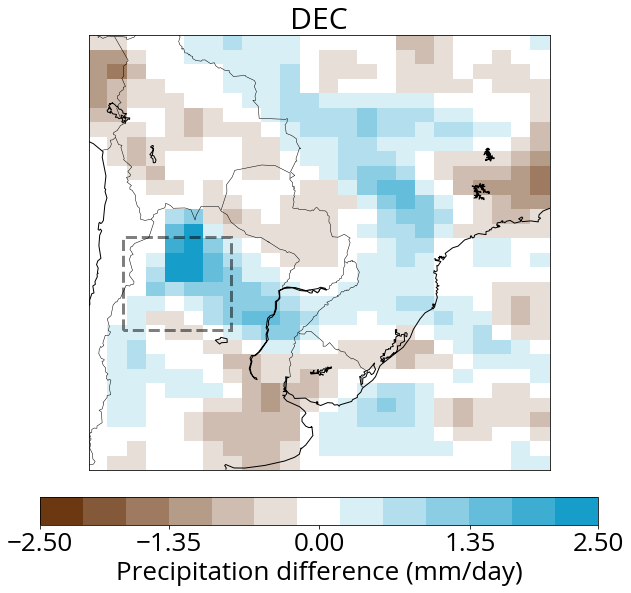

In [17]:
plot_cesm(diff_comp_dec_nal, pcp_control_tot.coords['lat'], pcp_control_tot.coords['lon'], vmin=-2.5, vmax=2.5, interval=0.4, ticks=[-2.5,-1.35,0,1.35,2.5],
          cblabel='Precipitation difference (mm/day)', month='DEC', cmap=matplotlib.colors.LinearSegmentedColormap.from_list("", ["#6c3811","white","#179DC9"]), outfile='diff_precip_dec_nal')

In [18]:
t_control = read_cesm('TREFHT', 'FHIST_SP_control', 'atm', 'cam')
t_dry_nal = read_cesm('TREFHT', 'FHIST_SP_dry_NAL', 'atm', 'cam')

/glade/scratch/cab478/archive/FHIST_SP_control/atm/hist/FHIST_SP_control.cam.h0.1979-2003.nc
/glade/scratch/cab478/archive/FHIST_SP_dry_NAL/atm/hist/FHIST_SP_dry_NAL.cam.h0.1979-2003.nc


In [19]:
t_control = t_control.resample(time='M').mean(dim='time')
t_dry_nal = t_dry_nal.resample(time='M').mean(dim='time')

In [20]:
t_diff_nal = t_dry_nal - t_control
t_diff_oct_nal = t_diff_nal.sel(time=t_diff_nal.time.dt.month==10)
t_diff_nov_nal = t_diff_nal.sel(time=t_diff_nal.time.dt.month==11)
t_diff_dec_nal = t_diff_nal.sel(time=t_diff_nal.time.dt.month==12)

In [21]:
t_comp_oct_nal = np.nanmean(t_diff_oct_nal, axis=0)
t_comp_nov_nal = np.nanmean(t_diff_nov_nal, axis=0)
t_comp_dec_nal = np.nanmean(t_diff_dec_nal, axis=0)

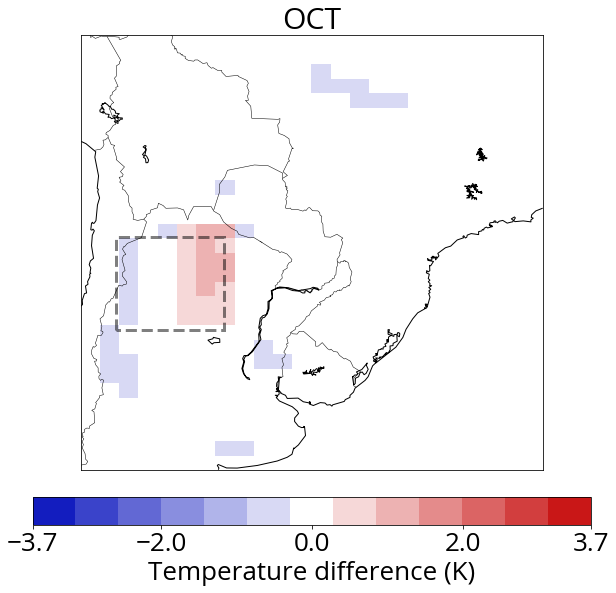

In [22]:
plot_cesm(t_comp_oct_nal, t_control.coords['lat'], t_control.coords['lon'], vmin=-3.7, vmax=3.7, interval=0.6, ticks=[-3.7,-2.0,0,2.0,3.7],
          cblabel='Temperature difference (K)', month='OCT', cmap=matplotlib.colors.LinearSegmentedColormap.from_list("", ["#131DBF","white","#C91717"]), outfile='diff_t_oct_nal')

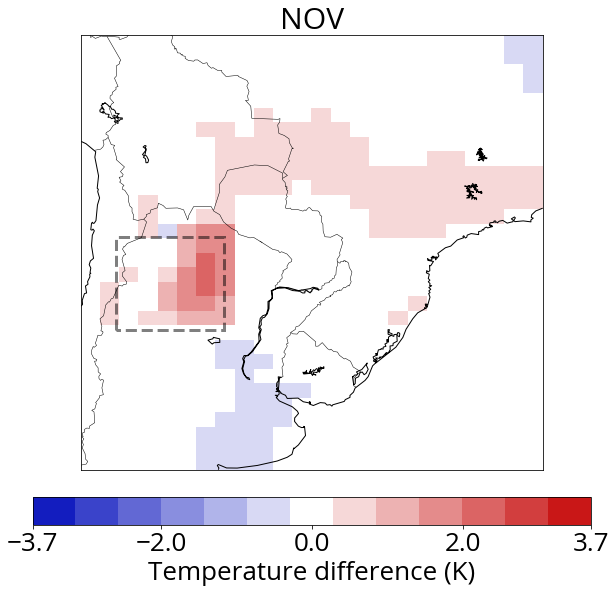

In [23]:
plot_cesm(t_comp_nov_nal, t_control.coords['lat'], t_control.coords['lon'], vmin=-3.7, vmax=3.7, interval=0.60, ticks=[-3.7,-2,0,2,3.7],
          cblabel='Temperature difference (K)', month='NOV', cmap=matplotlib.colors.LinearSegmentedColormap.from_list("", ["#131DBF","white","#C91717"]), outfile='diff_t_nov_nal')

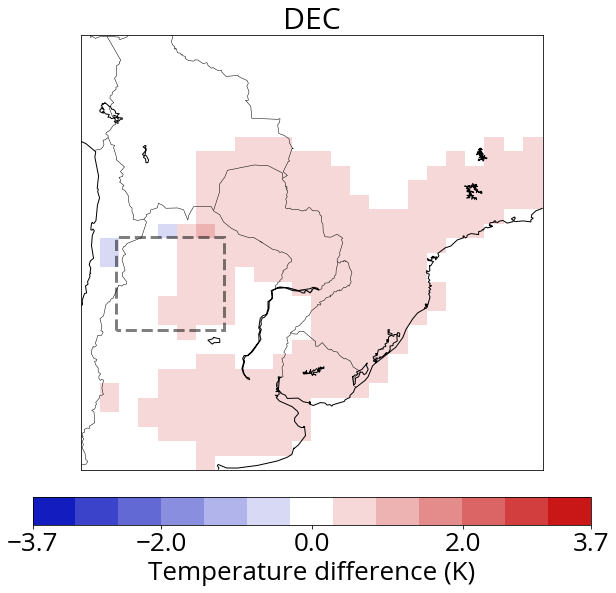

In [24]:
plot_cesm(t_comp_dec_nal, t_control.coords['lat'], t_control.coords['lon'], vmin=-3.7, vmax=3.7, interval=0.60, ticks=[-3.7,-2,0,2,3.7],
          cblabel='Temperature difference (K)', month='DEC', cmap=matplotlib.colors.LinearSegmentedColormap.from_list("", ["#131DBF","white","#C91717"]), outfile='diff_t_dec_nal')

In [8]:
sm_control = read_cesm('H2OSOI', 'FHIST_SP_control', 'lnd', 'clm2', exclude=True, no1=True, SM=True)
sm_dry_nal = read_cesm('H2OSOI', 'FHIST_SP_dry_NAL', 'lnd', 'clm2', nolast=True, SM=True)

/glade/scratch/cab478/archive/FHIST_SP_control/lnd/hist/FHIST_SP_control.clm2.h0.1979-2003.nc
/glade/scratch/cab478/archive/FHIST_SP_dry_NAL/lnd/hist/FHIST_SP_dry_NAL.clm2.h0.1979-2003.nc


In [9]:
sm_control = sm_control.resample(time='M').mean(dim='time')
sm_dry_nal = sm_dry_nal.resample(time='M').mean(dim='time')

/glade/u/home/cab478/anaconda3/lib/python3.7/site-packages/xarray/core/nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [10]:
sm_diff  = sm_dry_nal - sm_control
sm_diff_oct = sm_diff.sel(time=sm_diff.time.dt.month==10)
sm_diff_nov = sm_diff.sel(time=sm_diff.time.dt.month==11)
sm_diff_dec = sm_diff.sel(time=sm_diff.time.dt.month==12)

In [11]:
sm_diff_comp_oct = np.nanmean(sm_diff_oct, axis=0)
sm_diff_comp_nov = np.nanmean(sm_diff_nov, axis=0)
sm_diff_comp_dec = np.nanmean(sm_diff_dec, axis=0)

/glade/u/home/cab478/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: Mean of empty slice
  """Entry point for launching an IPython kernel.
/glade/u/home/cab478/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: Mean of empty slice
  
/glade/u/home/cab478/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: Mean of empty slice
  This is separate from the ipykernel package so we can avoid doing imports until


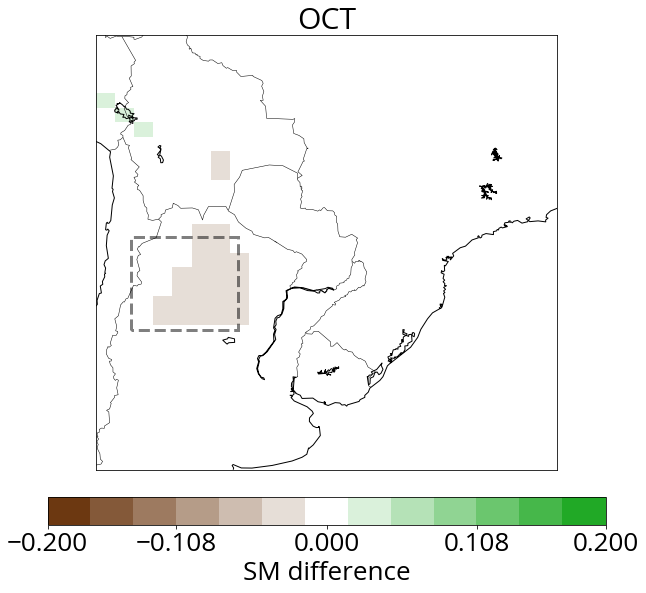

In [12]:
plot_cesm(sm_diff_comp_oct, sm_control.coords['lat'], sm_control.coords['lon'], vmin=-0.2, vmax=0.2, interval=0.033, ticks=[-0.2,-0.108,0,0.108,0.2],
          cblabel='SM difference', month='OCT', cmap=matplotlib.colors.LinearSegmentedColormap.from_list("", ["#6c3811","white","#21A926"]), outfile='diff_sm_oct_nal')

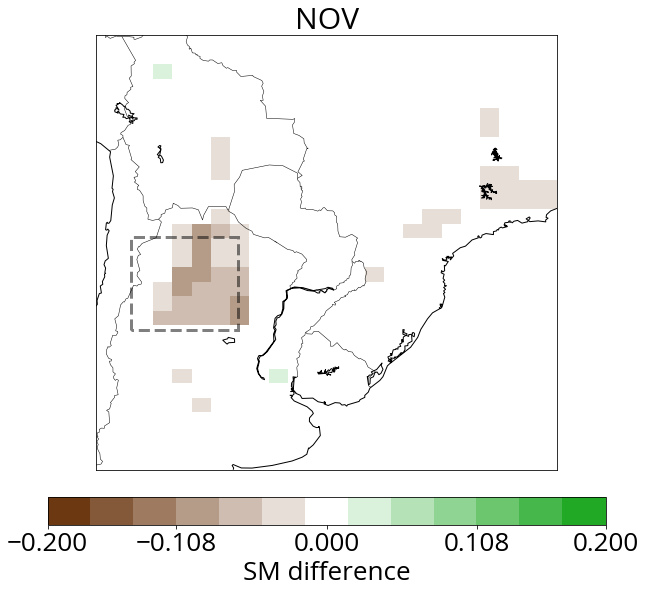

In [13]:
plot_cesm(sm_diff_comp_nov, sm_control.coords['lat'], sm_control.coords['lon'], vmin=-0.2, vmax=0.2, interval=0.033, ticks=[-0.2,-0.108,0,0.108,0.2],
          cblabel='SM difference', month='NOV', cmap=matplotlib.colors.LinearSegmentedColormap.from_list("", ["#6c3811","white","#21A926"]), outfile='diff_sm_nov_nal')

In [ ]:
plot_cesm(sm_diff_comp_dec, sm_control.coords['lat'], sm_control.coords['lon'], vmin=-0.2, vmax=0.2, interval=0.033, ticks=[-0.2,-0.108,0,0.108,0.2],
          cblabel='SM difference', month='DEC', cmap=matplotlib.colors.LinearSegmentedColormap.from_list("", ["#6c3811","white","#21A926"]), outfile='diff_sm_dec_nal')

In [8]:
u_control = read_cesm('U', 'FHIST_SP_control', 'atm', 'cam', plev=850., vinterp = True)
u_dry_nal = read_cesm('U', 'FHIST_SP_dry_NAL', 'atm', 'cam', plev=850., vinterp = True)

/glade/scratch/cab478/archive/FHIST_SP_control/atm/hist/FHIST_SP_control.cam.h0.1979-2003.nc
/glade/scratch/cab478/archive/FHIST_SP_dry_NAL/atm/hist/FHIST_SP_dry_NAL.cam.h0.1979-2003.nc


In [9]:
v_control = read_cesm('V', 'FHIST_SP_control', 'atm', 'cam', plev=850., vinterp = True)
v_dry_nal = read_cesm('V', 'FHIST_SP_dry_NAL', 'atm', 'cam', plev=850., vinterp = True)

/glade/scratch/cab478/archive/FHIST_SP_control/atm/hist/FHIST_SP_control.cam.h0.1979-2003.nc
/glade/scratch/cab478/archive/FHIST_SP_dry_NAL/atm/hist/FHIST_SP_dry_NAL.cam.h0.1979-2003.nc


In [10]:
ps_control = read_cesm('PS', 'FHIST_SP_control', 'atm', 'cam')
ps_dry_nal = read_cesm('PS', 'FHIST_SP_dry_NAL', 'atm', 'cam')

/glade/scratch/cab478/archive/FHIST_SP_control/atm/hist/FHIST_SP_control.cam.h0.1979-2003.nc
/glade/scratch/cab478/archive/FHIST_SP_dry_NAL/atm/hist/FHIST_SP_dry_NAL.cam.h0.1979-2003.nc


In [11]:
gh_control = read_cesm('Z3', 'FHIST_SP_control', 'atm', 'cam', plev=850., vinterp = True)
gh_dry_nal = read_cesm('Z3', 'FHIST_SP_dry_NAL', 'atm', 'cam', plev=850., vinterp = True)

/glade/scratch/cab478/archive/FHIST_SP_control/atm/hist/FHIST_SP_control.cam.h0.1979-2003.nc
/glade/scratch/cab478/archive/FHIST_SP_dry_NAL/atm/hist/FHIST_SP_dry_NAL.cam.h0.1979-2003.nc


In [12]:
gh_control = gh_control.where(ps_control > 85000.0)
gh_dry_nal = gh_dry_nal.where(ps_control > 85000.0)

In [13]:
u_control = u_control.where(ps_control > 85000.0)
u_dry_nal = u_dry_nal.where(ps_control > 85000.0)

In [14]:
v_control = v_control.where(ps_control > 85000.0)
v_dry_nal = v_dry_nal.where(ps_control > 85000.0)

In [15]:
u_control = u_control.resample(time='M').mean(dim='time')
u_dry_nal = u_dry_nal.resample(time='M').mean(dim='time')

/glade/u/home/cab478/anaconda3/lib/python3.7/site-packages/xarray/core/nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [16]:
v_control = v_control.resample(time='M').mean(dim='time')
v_dry_nal = v_dry_nal.resample(time='M').mean(dim='time')

In [29]:
u_control = u_control.where(u_control<100)
u_dry_nal = u_dry_nal.where(u_dry_nal<100)
v_control = v_control.where(v_control<100)
v_dry_nal = v_dry_nal.where(v_dry_nal<100)

In [30]:
u_diff_nal = u_dry_nal - u_control
#u_diff_nal[np.nonzero(np.asarray(u_diff_nal) > 100)] = np.NaN
u_diff_oct_nal = u_diff_nal.sel(time=u_diff_nal.time.dt.month==10)
u_diff_nov_nal = u_diff_nal.sel(time=u_diff_nal.time.dt.month==11)
u_diff_dec_nal = u_diff_nal.sel(time=u_diff_nal.time.dt.month==12)

In [31]:
v_diff_nal = v_dry_nal - u_control
#v_diff_nal[np.nonzero(np.asarray(v_diff_nal) > 100)] = np.NaN
v_diff_oct_nal = v_diff_nal.sel(time=v_diff_nal.time.dt.month==10)
v_diff_nov_nal = v_diff_nal.sel(time=v_diff_nal.time.dt.month==11)
v_diff_dec_nal = v_diff_nal.sel(time=v_diff_nal.time.dt.month==12)

In [32]:
u_diff_comp_oct_nal = np.nanmean(u_diff_oct_nal, axis=0)
u_diff_comp_nov_nal = np.nanmean(u_diff_nov_nal, axis=0)
u_diff_comp_dec_nal = np.nanmean(u_diff_dec_nal, axis=0)

/glade/u/home/cab478/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: Mean of empty slice
  """Entry point for launching an IPython kernel.
/glade/u/home/cab478/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: Mean of empty slice
  
/glade/u/home/cab478/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: Mean of empty slice
  This is separate from the ipykernel package so we can avoid doing imports until


In [33]:
v_diff_comp_oct_nal = np.nanmean(v_diff_oct_nal, axis=0)
v_diff_comp_nov_nal = np.nanmean(v_diff_nov_nal, axis=0)
v_diff_comp_dec_nal = np.nanmean(v_diff_dec_nal, axis=0)

/glade/u/home/cab478/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: Mean of empty slice
  """Entry point for launching an IPython kernel.
/glade/u/home/cab478/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: Mean of empty slice
  
/glade/u/home/cab478/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: Mean of empty slice
  This is separate from the ipykernel package so we can avoid doing imports until


In [34]:
gh_control = gh_control.where(gh_control<1e+30)
gh_dry_nal = gh_dry_nal.where(gh_dry_nal<1e+30)

In [35]:
gh_control = gh_control.resample(time='M').mean(dim='time')
gh_dry_nal = gh_dry_nal.resample(time='M').mean(dim='time')

/glade/u/home/cab478/anaconda3/lib/python3.7/site-packages/xarray/core/nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [36]:
gh_diff  = gh_dry_nal - gh_control
gh_diff[np.nonzero(np.asarray(gh_diff) > 100)] = np.NaN
gh_diff_oct = gh_diff.sel(time=gh_diff.time.dt.month==10)
gh_diff_nov = gh_diff.sel(time=gh_diff.time.dt.month==11)
gh_diff_dec = gh_diff.sel(time=gh_diff.time.dt.month==12)

/glade/u/home/cab478/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in greater
  


In [37]:
gh_diff_comp_oct = np.nanmean(gh_diff_oct, axis=0)
gh_diff_comp_nov = np.nanmean(gh_diff_nov, axis=0)
gh_diff_comp_dec = np.nanmean(gh_diff_dec, axis=0)

#gh_diff_comp_dec[np.nonzero(gh_diff_comp_dec > 4)] = np.NaN

/glade/u/home/cab478/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: Mean of empty slice
  """Entry point for launching an IPython kernel.
/glade/u/home/cab478/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: Mean of empty slice
  
/glade/u/home/cab478/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: Mean of empty slice
  This is separate from the ipykernel package so we can avoid doing imports until


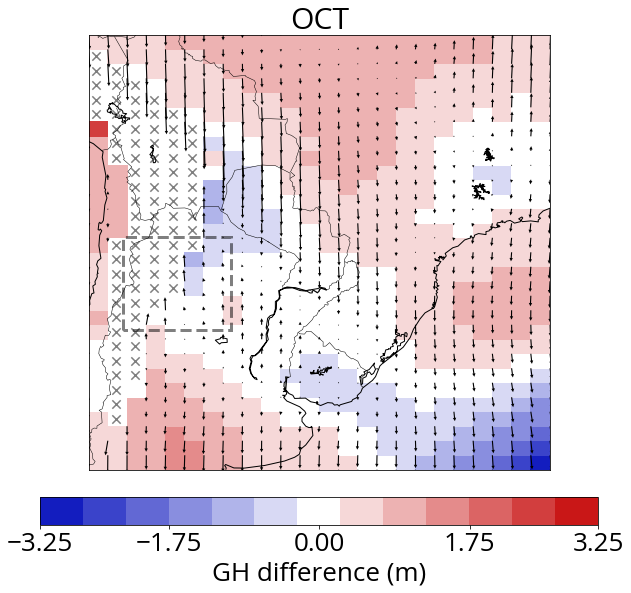

In [53]:
plot_cesm(gh_diff_comp_oct, gh_control.coords['lat'], gh_control.coords['lon'], vmin=-3.25, vmax=3.25, interval=0.5, ticks=[-3.25,-1.75,0,1.75,3.25],
          cblabel='GH difference (m)', month='OCT', cmap=matplotlib.colors.LinearSegmentedColormap.from_list("", ["#131DBF","white","#C91717"]), outfile='diff_gh_oct_nal',
          winds=True, U=u_diff_comp_oct_nal, V=v_diff_comp_oct_nal, plotnan=True)

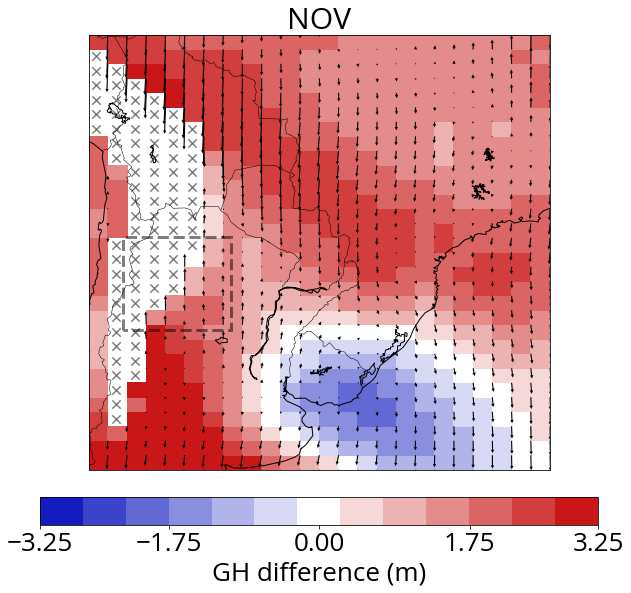

In [54]:
plot_cesm(gh_diff_comp_nov, gh_control.coords['lat'], gh_control.coords['lon'], vmin=-3.25, vmax=3.25, interval=0.5, ticks=[-3.25,-1.75,0,1.75,3.25],
          cblabel='GH difference (m)', month='NOV', cmap=matplotlib.colors.LinearSegmentedColormap.from_list("", ["#131DBF","white","#C91717"]), outfile='diff_gh_nov_nal',
          winds=True, U=u_diff_comp_nov_nal, V=v_diff_comp_nov_nal, plotnan=True)

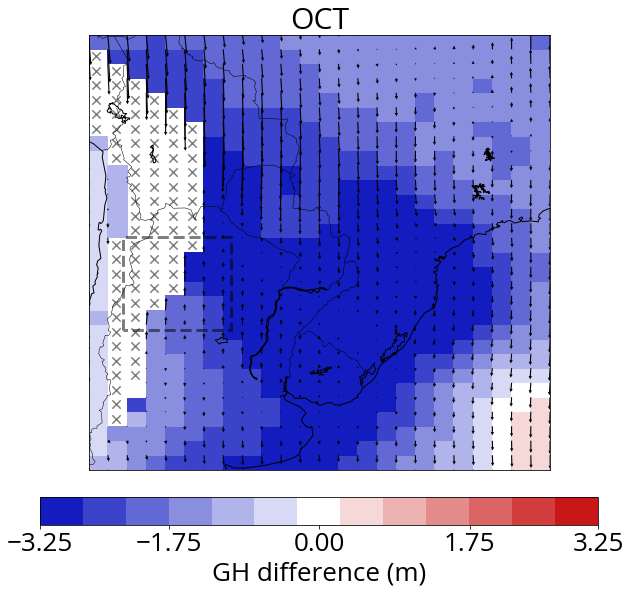

In [55]:
plot_cesm(gh_diff_comp_dec, gh_control.coords['lat'], gh_control.coords['lon'],vmin=-3.25, vmax=3.25, interval=0.5, ticks=[-3.25,-1.75,0,1.75,3.25],
          cblabel='GH difference (m)', month='OCT', cmap=matplotlib.colors.LinearSegmentedColormap.from_list("", ["#131DBF","white","#C91717"]), outfile='diff_gh_dec_nal',
          winds=True, U=u_diff_comp_dec_nal, V=v_diff_comp_dec_nal, plotnan=True)